In [1]:
from ast import Mult
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
import seaborn as sns
import numpy as np
from collections import Counter

In [36]:
X, y = make_multilabel_classification(n_samples=10000, n_features=10, n_classes=3, n_labels=2)
X_torch = torch.FloatTensor(X)
y_torch = torch.FloatTensor(y)

In [37]:
# %% train test split
X_train, X_test, y_train, y_test = train_test_split(X_torch, y_torch, test_size = 0.2)

In [38]:
X

array([[ 2.,  4.,  5., ...,  0.,  6., 12.],
       [ 7.,  4.,  4., ...,  4.,  8.,  7.],
       [ 3.,  3.,  5., ...,  7.,  2.,  5.],
       ...,
       [ 4.,  2.,  6., ...,  8.,  5.,  6.],
       [ 1.,  5.,  4., ...,  6.,  8.,  9.],
       [ 7.,  9.,  0., ...,  4.,  5.,  4.]], shape=(10000, 10))

In [39]:
y

array([[0, 0, 1],
       [1, 1, 1],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]], shape=(10000, 3))

<Axes: >

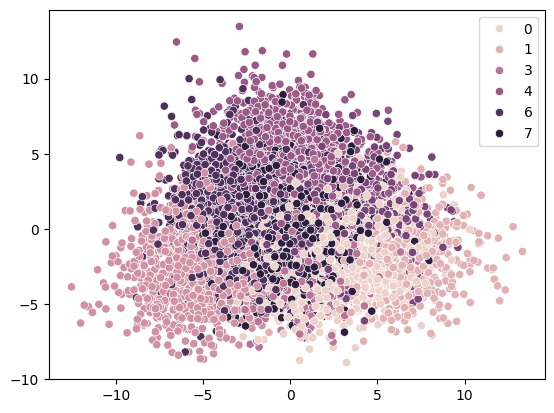

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y[:,0] + 2 * y[:, 1]  + 4 * y[:, 2])

In [45]:
# %% dataset and dataloader
class MultilabelDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

multilabel_data = MultilabelDataset(X_train, y_train)
train_loader = DataLoader(dataset = multilabel_data, batch_size=10)

In [42]:
class MultilabelNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [47]:
# TODO: define input and output dim
input_dim = X.shape[1]
output_dim = y.shape[1]
hidden = 22

model = MultilabelNetwork(input_size=input_dim, output_size=output_dim, hidden_size=hidden)


In [ ]:
# TODO: set up loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
losses = []
slope, bias = [], []
number_epochs = 100


Epoch 0, Loss: 0.58982914686203
Epoch 10, Loss: 0.5388997793197632
Epoch 20, Loss: 0.5512873530387878
Epoch 30, Loss: 0.5452669858932495
Epoch 40, Loss: 0.5251439809799194
Epoch 50, Loss: 0.5311310291290283
Epoch 60, Loss: 0.5367507338523865
Epoch 70, Loss: 0.5592717528343201
Epoch 80, Loss: 0.5590187311172485
Epoch 90, Loss: 0.5734398365020752


In [57]:

# TODO: implement training loop
for epoch in range(number_epochs):
    
    for j, (X, y) in enumerate(train_loader):
        
        optimizer.zero_grad()

        y_hat = model(X)

        loss = loss_fn(y_hat, y)
        losses.append(loss.item())

        loss.backward()

        optimizer.step()

        
    if (epoch % 10 == 0):
        print(f"Epoch {epoch}, Loss: {loss.data}")
    

Epoch 0, Loss: 0.5735400319099426
Epoch 10, Loss: 0.5496397018432617
Epoch 20, Loss: 0.5492187142372131
Epoch 30, Loss: 0.5474587678909302
Epoch 40, Loss: 0.5491151213645935
Epoch 50, Loss: 0.5735899209976196
Epoch 60, Loss: 0.5588675737380981
Epoch 70, Loss: 0.5861035585403442
Epoch 80, Loss: 0.5494872331619263
Epoch 90, Loss: 0.5414543151855469


<Axes: >

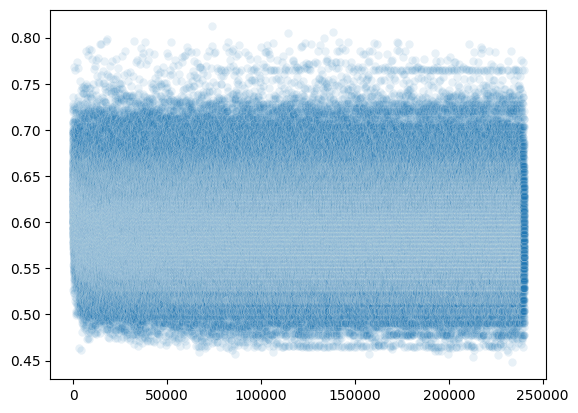

In [59]:
sns.scatterplot(x=range(len(losses)), y=losses, alpha=0.1)

In [60]:
X_test_torch = torch.FloatTensor(X_test)
with torch.no_grad():
    y_test_hat = model(X_test_torch).round()

In [64]:
y_test_str = np.array([i for i in y_test.detach().numpy()])
y_test_str

array([[1., 1., 1.],
       [0., 0., 0.],
       [0., 1., 1.],
       ...,
       [0., 1., 1.],
       [0., 0., 1.],
       [1., 0., 1.]], shape=(2000, 3), dtype=float32)

In [65]:
test_acc = accuracy_score(y_test, y_test_hat)
print(f"Test accuracy: {test_acc * 100}%")

Test accuracy: 53.25%
